In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import glob, os

os.chdir('../core')
import stitching_ssid as ssid

os.chdir('../../../../pyRRHDLDS/core')
import ssm_scripts

import pprint

# Generate LTI system

$ y_t = C x_t + D u_t $  

$ x_{t+1} = A x_t + B u_t $

$ y_t \in \mathbb{R}^p, x_t \in \mathbb{R}^n ,u_t \in \mathbb{R}^m, t \in \{0, \ldots, T \}  $ 


 Chosen system and simulation sizes: 
 (p, n, m, T) =  (4, 3, 2, 100)

 Generated input, output and state trajectories:


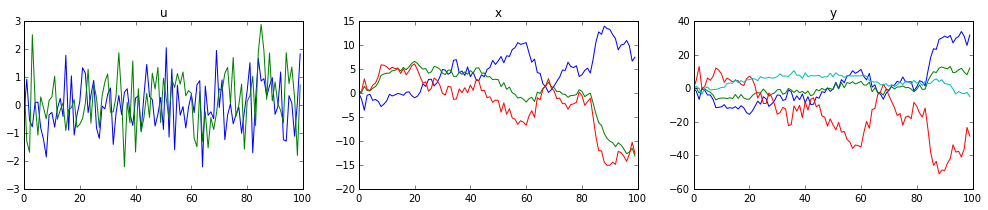

In [10]:
p, n, m, T = 4, 3, 2, 100

print('\n Chosen system and simulation sizes: ')
print(' (p, n, m, T) = ', (p, n, m, T))

pars_true, options = ssm_scripts.gen_pars(x_dim=n, y_dim=p, u_dim=m, pars_in=None, obs_scheme=None, 
                                 gen_A='full', lts=np.linspace(0.95, 0.99, n), gen_B='random', gen_Q='identity', 
                                 gen_mu0='zero', gen_d='zero', gen_R='zero', diag_R_flag=True)
pars_true['D'] = np.random.normal(size=(p,m))

# Return function sim_sys() that returns output given inputs
sim_sys = ssid.d_system(pars_true, stype='LTI')

# Fix input signal (given system matrices, will fix the output!)
inputs = np.random.normal(0,1,size=(T,m))

# Compute x, y
data, stateseq = sim_sys(inputs)

# Visualize    
print('\n Generated input, output and state trajectories:')
plt.figure(figsize=(17,3))
plt.subplot(1,3,3)
plt.plot(data)
plt.title('y')
plt.subplot(1,3,2)
plt.plot(stateseq)
plt.title('x')
plt.subplot(1,3,1)
plt.plot(inputs)
plt.title('u')
plt.show()

# Ho-Kalman's method 

Ho-Kalman reconstructs the system matrices $A,B,C,D$ from the impulse responses $G_t$ of the system.

We will use the true system matrices to simulate the impulse reponses $G_t$, as the system ouput $y_t$ of a system at rest ($x_0 = 0$) upon stimulation with an impulse at $t=0$, i.e. $u_0 = 1, u_t = 0$ for $t>0$.

- ground truth input response functions (using ground-truth $A,B,C,D$), 
- system initially at rest x_0 = 0
- impulse responses of length $k+l \geq 2n$ are sufficient
- latent dimensionality $\hat{n}$ is estimated from the (Hankel matrix of) impulse responses
- $(A,B,C)$ has to be minimal for this to work, i.e. $(A,C)$ being observable, $(B,C)$ being reachable
- there is two ways to get $A$ (reachability or observability matrix), both are implemented



true and estimated latent dim. : (n, n_hat) =  (3, 3)

 We check system identification quality by comparing true and estimated outputs to *novel* inputs 
 
worst-cell reconstruction MSE =  1.00020816124e-24
average reconstruction MSE =  4.68518202295e-25


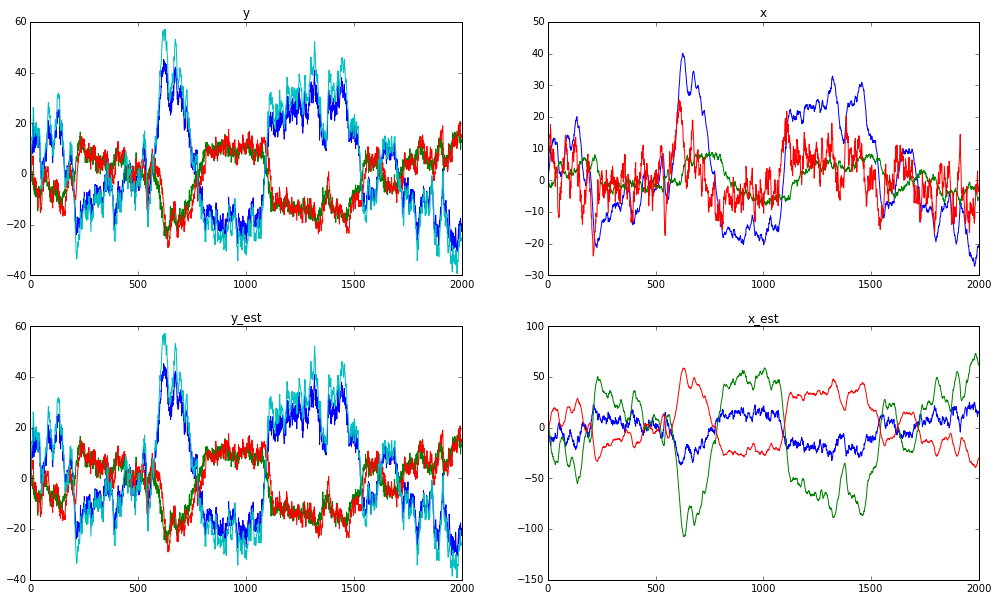

In [3]:
# set-up 
k, l = n, n # algorithm is guaranteed to work (given assumptions are met) if k,l are at least ground-truth n
G_true = ssid.d_calc_impulse_responses(pars_true)
comp_A_from = 'observability' # can get A either from observability or from reachability matrix

# Do Ho-Kalman
pars_est, obs_est , reach_est , _ , n_est = ssid.Ho_Kalman(G_true,k,l,comp_A_from)
pars_est['mu0'] = np.zeros(n)

# Since there is no noise, we can just check system identification by feeding novel inputs into the true and
# our reconstructed system - the outputs should be identical (note this depends on knowing that x(0)=0)
inputs = np.random.normal(0,1,size=(T,m))
data, stateseq = sim_sys(inputs)
data_est, stateseq_est = ssid.d_sim_system_LTI(pars_est, inputs)
print('')
print('true and estimated latent dim. : (n, n_hat) = ', (n, n_est))

err = ssid.data_reconstruction_MSE(data, data_est)
print('\n We check system identification quality by comparing true and estimated outputs to *novel* inputs \n ')
print('worst-cell reconstruction MSE = ', err.max())
print('average reconstruction MSE = ', err.mean())

# Visualize    
plt.figure(figsize=(17,10))
plt.subplot(2,2,1)
plt.plot(data)
plt.title('y')
plt.subplot(2,2,3)
plt.plot(data_est)
plt.title('y_est')
plt.subplot(2,2,2)
plt.plot(stateseq)
plt.title('x')
plt.subplot(2,2,4)
plt.plot(stateseq_est)
plt.title('x_est')
plt.show()

# naive Ho-Kalman's method on systems not at rest

- imulse input $$ u_t =
\left\{
	\begin{array}{ll}
		1 & \mbox{if } t = 0 \\
		0   & \mbox{if } 0 < t < 2n
	\end{array}
\right.$$
- estimating input responses from output data of system
- assuming $x_0 =0$ even though the system initially is **not** at rest


In [4]:
k, l = n, n # algorithm is guaranteed to work (given assumptions are met) if k,l are at least n
Gs, X0 = ssid.d_est_input_responses(pars_true,k+l,0)
pars_est, obs_est , reach_est , _ , n_est = ssid.Ho_Kalman(Gs[0:],k,l,comp_A_from)

print('\n Applying Ho-Kalman to improper impulse responses of the ground-truth system')
print('(improper means that x(0)~=0, so that the impulse responses superimpose with CA^{t-1}x(0))')

print('\n The estimated parameters B,D will be wrong, but we can correct using the ground-truth x(0)')

print('\n true and estimated D \n')
print(pars_true['D'])
print('')
print(pars_est['D'])
print('\n true and estimated C*B \n')
print(pars_true['C'].dot(pars_true['B']))
print('')
print(pars_est['C'].dot(pars_est['B']))
print('\n true and estimated C*A*B \n')
print(pars_true['C'].dot(pars_true['A'].dot(pars_true['B'])))
print('')
print(pars_est['C'].dot(pars_est['A']).dot(pars_est['B']))

print('\n true and estimated tilde{D} (correcting with true x(0)) \n ')
print(pars_true['D'] + pars_true['C'].dot(X0.T))
print('')
print(pars_est['D'])

print('\n true and estimated tilde{C}*tilde{B} (correcting with true x(0)) \n')
print(pars_true['C'].dot(pars_true['B']) + pars_true['C'].dot(pars_true['A'].dot(X0.T)))
print('')
print(pars_est['C'].dot(pars_est['B']))





 Applying Ho-Kalman to improper impulse responses of the ground-truth system
(improper means that x(0)~=0, so that the impulse responses superimpose with CA^{t-1}x(0))

 The estimated parameters B,D will be wrong, but we can correct using the ground-truth x(0)

 true and estimated D 

[[ 1.35987447  0.32255173]
 [-0.62933356 -1.55092377]
 [-0.0141101  -0.56505447]
 [-1.73550647  0.3809286 ]]

[[ 11.79047266   9.62575596]
 [ -5.10374146  -4.39143033]
 [ -3.67516822  -5.47328143]
 [ 11.94966698  12.2370959 ]]

 true and estimated C*B 

[[ 1.222377   -1.04135465]
 [ 0.10354011 -0.03532225]
 [ 0.86168757 -0.95235327]
 [ 1.85496211 -1.625195  ]]

[[ 11.61782884   8.18447936]
 [ -4.4708741   -2.90134408]
 [ -3.00858796  -5.86347685]
 [ 15.45102135  10.12429406]]

 true and estimated C*A*B 

[[ 1.23982892 -1.06138486]
 [ 0.03632104  0.03075989]
 [ 0.7482995  -0.83496839]
 [ 1.85710286 -1.63005891]]

[[ 11.59661979   8.08725723]
 [ -4.62821004  -2.85858582]
 [ -3.31549854  -5.74696382]
 [ 15.

# corrected Ho-Kalman's method on systems not at rest

- extended imulse input $$ u_t =
\left\{
	\begin{array}{ll}
        0 & \mbox{if } -n < t < 0 \\
		1 & \mbox{if } t = 0 \\
		0 & \mbox{if } 0 < t < 2n
	\end{array}
\right.$$
- estimating input responses from output data of system
- using Ho-Kalman ill-assuming $x_0 =0$, then correcting the system matrix estimates


In [5]:
k, l = n, n # algorithm is guaranteed to work (given assumptions are met) if k,l are at least n
pars_est, sqs, n_est, X0_est = ssid.Ho_Kalman_nonzero_init(pars_true, k, l)

print('\n Applying Ho-Kalman to improper impulse responses of the ground-truth system')
print(' and correcting for this using observability and an extended (zero-padded) input sequence')
print('\n true and estimated D')
print(pars_true['D'])
print('')
print(pars_est['D'])
print('\n true and estimated C*B')
print(pars_true['C'].dot(pars_true['B']))
print('')
print(pars_est['C'].dot(pars_est['B']))
print('\n true and estimated C*A*B')
print(pars_true['C'].dot(pars_true['A'].dot(pars_true['B'])))
print('')
print(pars_est['C'].dot(pars_est['A']).dot(pars_est['B']))



 Applying Ho-Kalman to improper impulse responses of the ground-truth system
 and correcting for this using observability and an extended (zero-padded) input sequence

 true and estimated D
[[ 1.35987447  0.32255173]
 [-0.62933356 -1.55092377]
 [-0.0141101  -0.56505447]
 [-1.73550647  0.3809286 ]]

[[ 1.35987447  0.32255173]
 [-0.62933356 -1.55092377]
 [-0.0141101  -0.56505447]
 [-1.73550647  0.3809286 ]]

 true and estimated C*B
[[ 1.222377   -1.04135465]
 [ 0.10354011 -0.03532225]
 [ 0.86168757 -0.95235327]
 [ 1.85496211 -1.625195  ]]

[[ 1.222377   -1.04135465]
 [ 0.10354011 -0.03532225]
 [ 0.86168757 -0.95235327]
 [ 1.85496211 -1.625195  ]]

 true and estimated C*A*B
[[ 1.23982892 -1.06138486]
 [ 0.03632104  0.03075989]
 [ 0.7482995  -0.83496839]
 [ 1.85710286 -1.63005891]]

[[ 1.23982892 -1.06138486]
 [ 0.03632104  0.03075989]
 [ 0.7482995  -0.83496839]
 [ 1.85710286 -1.63005891]]


# stitching Ho-Kalman for systems not at rest, stitching impulse responses

- extended imulse input $$ u_t =
\left\{
	\begin{array}{ll}
        0 & \mbox{if } -n < t < 0 \\
		1 & \mbox{if } t = 0 \\
		0 & \mbox{if } 0 < t < 2n
	\end{array}
\right.$$
- estimating input responses $G^i_t$ individually for each subpopulation from output data of system
- using Ho-Kalman on each subpopulation, ill-assuming $x_0 =0$ and then correcting the system matrix estimates $(A^i, B^i, C^i, D^i)$
- stitching the subpopulations by stitching the impulse responses ($G^i_t \rightarrow G_t$) before applying Ho-Kalman once more (now for the whole system)


In [6]:
k, l = n, n # algorithm is guaranteed to work (given assumptions are met) if k,l are at least n
sub_pops = ((0,1), (1,2), (2,3))
method = 'impulses' # stitching using impulse responses
pars_est, n_est = ssid.stitching_Ho_Kalman(pars_true, sub_pops, k, method=method)

print('\n true and estimated D')
print(pars_true['D'])
print('')
print(pars_est['D'])
print('\n true and estimated C*B')
print(pars_true['C'].dot(pars_true['B']))
print('')
print(pars_est['C'].dot(pars_est['B']))
print('\n true and estimated C*A*B')
print(pars_true['C'].dot(pars_true['A'].dot(pars_true['B'])))
print('')
print(pars_est['C'].dot(pars_est['A']).dot(pars_est['B']))


 true and estimated D
[[ 1.35987447  0.32255173]
 [-0.62933356 -1.55092377]
 [-0.0141101  -0.56505447]
 [-1.73550647  0.3809286 ]]

[[ 1.35987447  0.32255173]
 [-0.62933356 -1.55092377]
 [-0.0141101  -0.56505447]
 [-1.73550647  0.3809286 ]]

 true and estimated C*B
[[ 1.222377   -1.04135465]
 [ 0.10354011 -0.03532225]
 [ 0.86168757 -0.95235327]
 [ 1.85496211 -1.625195  ]]

[[ 1.222377   -1.04135465]
 [ 0.10354011 -0.03532225]
 [ 0.86168757 -0.95235327]
 [ 1.85496211 -1.625195  ]]

 true and estimated C*A*B
[[ 1.23982892 -1.06138486]
 [ 0.03632104  0.03075989]
 [ 0.7482995  -0.83496839]
 [ 1.85710286 -1.63005891]]

[[ 1.23982892 -1.06138486]
 [ 0.03632104  0.03075989]
 [ 0.7482995  -0.83496839]
 [ 1.85710286 -1.63005891]]


# stitching Ho-Kalman for systems not at rest, aligning system matrices

- extended imulse input $$ u_t =
\left\{
	\begin{array}{ll}
        0 & \mbox{if } -n < t < 0 \\
		1 & \mbox{if } t = 0 \\
		0 & \mbox{if } 0 < t < 2n
	\end{array}
\right.$$
- estimating input responses $G^i_t$ individually for each subpopulation from output data of system
- using Ho-Kalman on each subpopulation, ill-assuming $x_0 =0$ and then correcting the system matrix estimates $(A^i, B^i, C^i, D^i)$
- stitching the subpopulations by explictily rotating the obtained subpopulation system matrices $(A^i, B^i, C^i, D^i)$ using constraints obtained from observability matrices $\mathcal{O}_k$ and reachability matrices $\mathcal{C}_l$ under pairs of subpopulations $i \neq j$


In [9]:
k, l = n, n # algorithm is guaranteed to work (given assumptions are met) if k,l are at least n
sub_pops = (np.array((0,1)), np.array((1,2)), np.array((2,3)))

method = 'parameters_reach' # '_reach' to use reachability matrix, '_obs' for using observability matrix

pars_est, n_est = ssid.stitching_Ho_Kalman(pars_true, sub_pops, k, method=method)

print('\n true and estimated D')
print(pars_true['D'])
print('')
print(pars_est['D'])
print('\n true and estimated C*B')
print(pars_true['C'].dot(pars_true['B']))
print('')
print(pars_est['C'].dot(pars_est['B']))
print('\n true and estimated C*A*B')
print(pars_true['C'].dot(pars_true['A'].dot(pars_true['B'])))
print('')
print(pars_est['C'].dot(pars_est['A']).dot(pars_est['B']))



 true and estimated D
[[ 1.35987447  0.32255173]
 [-0.62933356 -1.55092377]
 [-0.0141101  -0.56505447]
 [-1.73550647  0.3809286 ]]

[[ 1.35987447  0.32255173]
 [-0.62933356 -1.55092377]
 [-0.0141101  -0.56505447]
 [-1.73550647  0.3809286 ]]

 true and estimated C*B
[[ 1.222377   -1.04135465]
 [ 0.10354011 -0.03532225]
 [ 0.86168757 -0.95235327]
 [ 1.85496211 -1.625195  ]]

[[ 1.222377   -1.04135465]
 [ 0.10354011 -0.03532225]
 [ 0.86168757 -0.95235327]
 [ 1.85496211 -1.625195  ]]

 true and estimated C*A*B
[[ 1.23982892 -1.06138486]
 [ 0.03632104  0.03075989]
 [ 0.7482995  -0.83496839]
 [ 1.85710286 -1.63005891]]

[[ 1.23982892 -1.06138486]
 [ 0.03632104  0.03075989]
 [ 0.7482995  -0.83496839]
 [ 1.85710286 -1.63005891]]
